In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
df = pd.read_csv("Hyundaistock.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,147500.0,148000.0,143500.0,144000.0,116768.625000,445332
1,2016-01-05,143000.0,145000.0,142000.0,143500.0,116363.179688,530496
2,2016-01-06,144000.0,145000.0,139000.0,140000.0,113525.023438,769406
3,2016-01-07,138500.0,140000.0,137500.0,137500.0,111497.820312,586187
4,2016-01-08,134500.0,138000.0,133500.0,136500.0,110686.914062,888701


In [3]:
closed_prices = df["Close"]
closed_prices.head()

0    144000.0
1    143500.0
2    140000.0
3    137500.0
4    136500.0
Name: Close, dtype: float64

In [4]:
seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()


Data processing

In [5]:
X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

X = np.array(X)[... , None]
y = np.array(y)[... , None]
    
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

In [6]:
class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
model = Model(1 , 64)

In [7]:
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

num_epochs = 100

In [8]:
for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)

#Back Propogationp part
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())


10 epoch loss 0.089816324
20 epoch loss 0.044201534
30 epoch loss 0.028220301
40 epoch loss 0.02363308
50 epoch loss 0.020483071
60 epoch loss 0.015664648
70 epoch loss 0.009006337
80 epoch loss 0.0025565966
90 epoch loss 0.0027973924


# As we can see above that the loss is decreasing little by little and reached nearly Zero.

# Model Evaluation

In [9]:
model.eval()
with torch.no_grad():
    output = model(test_x)

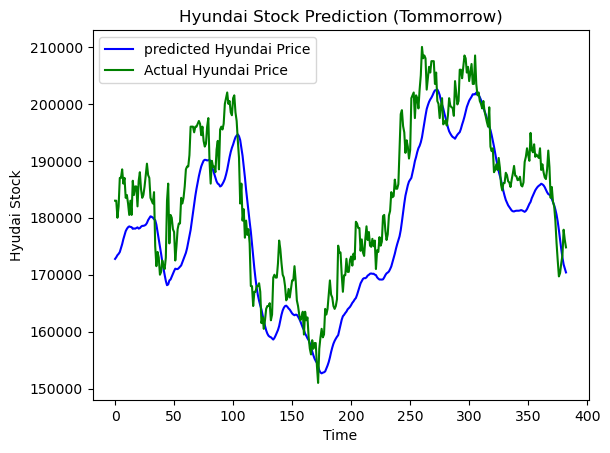

In [12]:
pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())

plt.plot(pred.squeeze() , color = "blue" , label = "predicted Hyundai Price")
plt.plot(real.squeeze() , color = "green" , label = "Actual Hyundai Price")
plt.xlabel('Time')
plt.ylabel('Hyudai Stock')
plt.title('Hyundai Stock Prediction (Tommorrow)')
plt.legend()
plt.show()